## First Iteration: Planwise Recommendation System

In [31]:
import eda_pipeline

import sys
import logging
import numpy as np
import pandas as pd

import os
import sys
import numpy as np
import lightgbm as lgb
import pandas as pd
import category_encoders as ce
from tempfile import TemporaryDirectory
from sklearn.metrics import roc_auc_score, log_loss

import recommenders.datasets.criteo as criteo
import recommenders.models.lightgbm.lightgbm_utils as lgb_utils
from recommenders.utils.notebook_utils import store_metadata

print("System version: {}".format(sys.version))
print("LightGBM version: {}".format(lgb.__version__))

System version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ]
LightGBM version: 4.5.0


## Paths

In [32]:
path_destinations = "archive/Expanded_Destinations.csv"
path_reviews = "archive/Final_Updated_Expanded_Reviews.csv"
path_user_history = "archive/Final_Updated_Expanded_UserHistory.csv"
path_users = "archive/Final_Updated_Expanded_Users.csv"

## Load the data into the EDAPipeline

In [33]:
eda_destinations = eda_pipeline.EDAPipeline(path_destinations)
eda_reviews = eda_pipeline.EDAPipeline(path_reviews)
eda_user_history = eda_pipeline.EDAPipeline(path_user_history)
eda_users = eda_pipeline.EDAPipeline(path_users)


### EDA: DESTINATIONS

In [34]:
eda_destinations.load_data()


Dataset Shape: (1000, 6)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DestinationID    1000 non-null   int64  
 1   Name             1000 non-null   object 
 2   State            1000 non-null   object 
 3   Type             1000 non-null   object 
 4   Popularity       1000 non-null   float64
 5   BestTimeToVisit  1000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 47.0+ KB


First few rows:

   DestinationID               Name              State        Type  Popularity BestTimeToVisit
0              1          Taj Mahal      Uttar Pradesh  Historical    8.691906         Nov-Feb
1              2        Goa Beaches                Goa       Beach    8.605032         Nov-Mar
2              3        Jaipur City          Rajasthan        City    9.225372         Oct-Mar
3              4  Kerala

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
0,1,Taj Mahal,Uttar Pradesh,Historical,8.691906,Nov-Feb
1,2,Goa Beaches,Goa,Beach,8.605032,Nov-Mar
2,3,Jaipur City,Rajasthan,City,9.225372,Oct-Mar
3,4,Kerala Backwaters,Kerala,Nature,7.977386,Sep-Mar
4,5,Leh Ladakh,Jammu and Kashmir,Adventure,8.399822,Apr-Jun
...,...,...,...,...,...,...
995,996,Taj Mahal,Uttar Pradesh,Historical,8.133818,Nov-Feb
996,997,Goa Beaches,Goa,Beach,8.203519,Nov-Mar
997,998,Jaipur City,Rajasthan,City,8.308435,Oct-Mar
998,999,Kerala Backwaters,Kerala,Nature,8.961741,Sep-Mar


In [35]:
eda_destinations.check_data_quality()


Statistical Summary:

       DestinationID  Popularity
count        1000.00     1000.00
mean          500.50        8.51
std           288.82        0.57
min             1.00        7.50
25%           250.75        8.03
50%           500.50        8.50
75%           750.25        9.02
max          1000.00        9.50


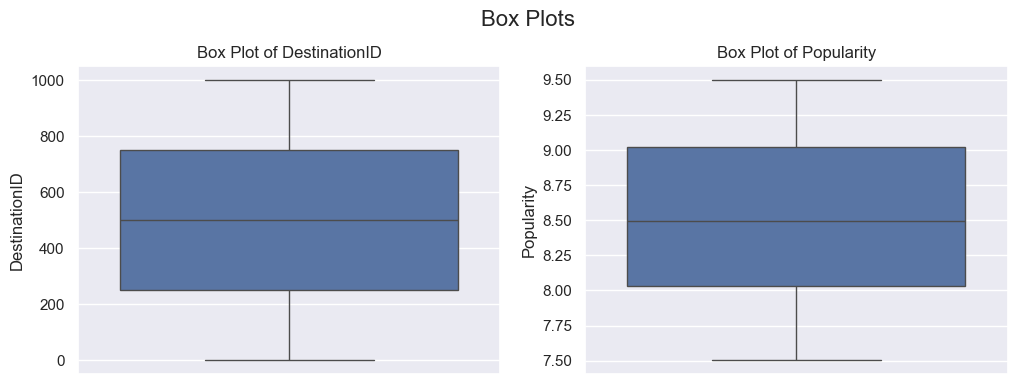

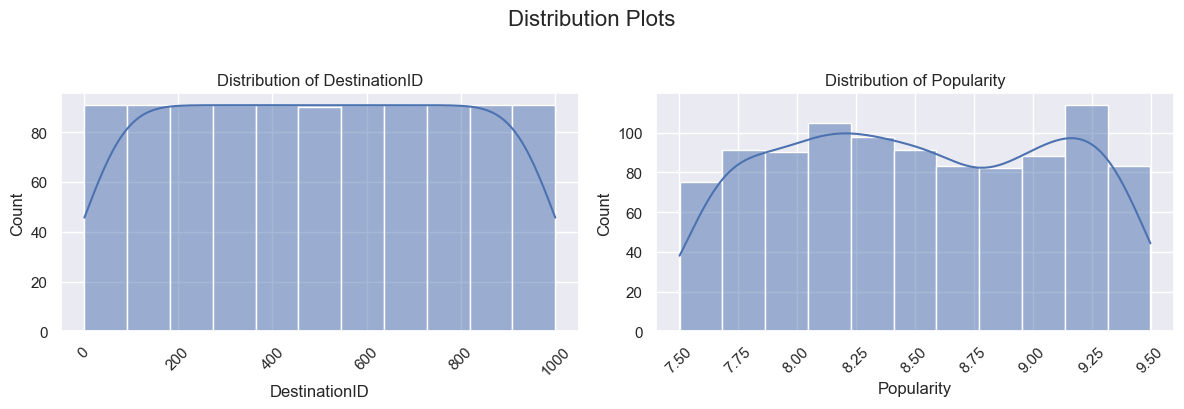

<Figure size 640x480 with 0 Axes>


Summary statistics:

       DestinationID  Popularity
count        1000.00     1000.00
mean          500.50        8.51
std           288.82        0.57
min             1.00        7.50
25%           250.75        8.03
50%           500.50        8.50
75%           750.25        9.02
max          1000.00        9.50


In [36]:
eda_destinations.analyze_numerical()

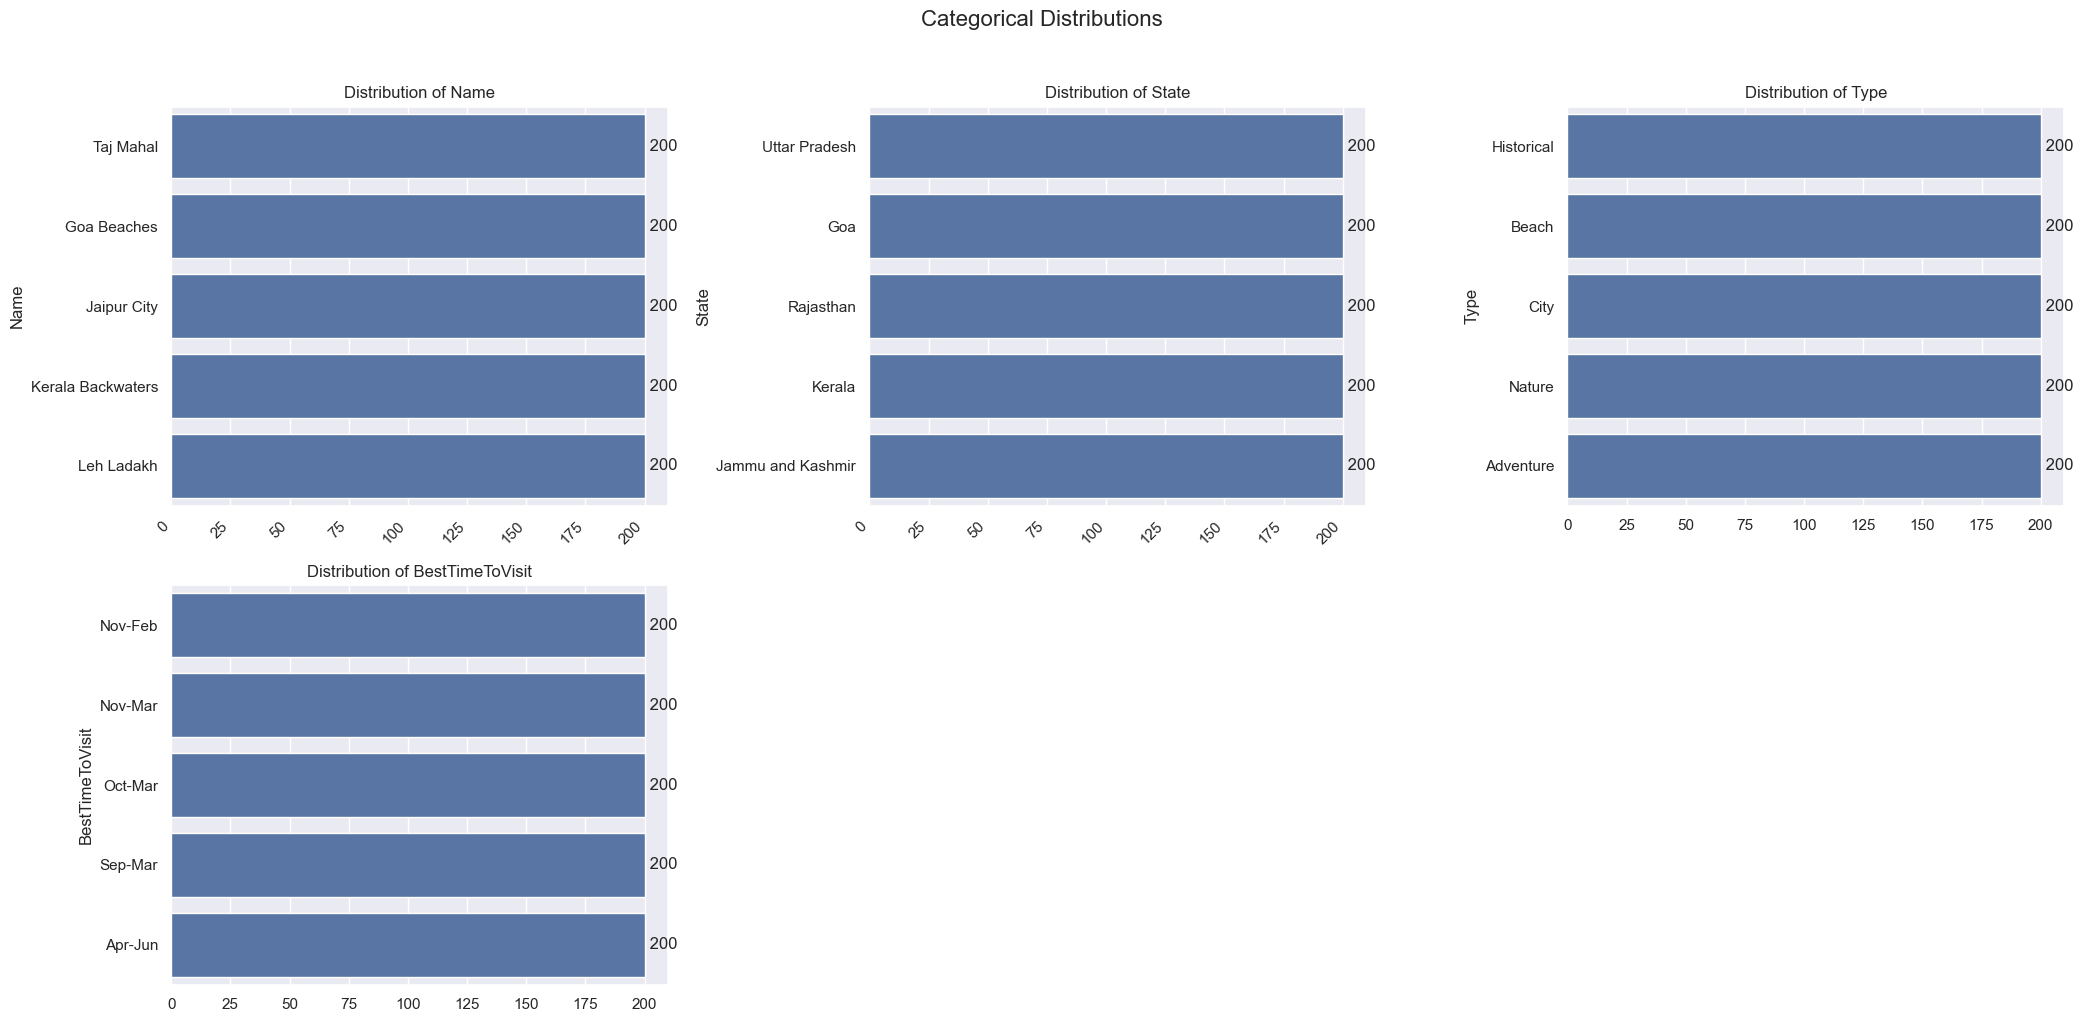


Frequency distributions (proportions):

Name:
Name
Taj Mahal            0.2
Goa Beaches          0.2
Jaipur City          0.2
Kerala Backwaters    0.2
Leh Ladakh           0.2
Number of unique values: 5
Most common value: Goa Beaches (20.00%)

State:
State
Uttar Pradesh        0.2
Goa                  0.2
Rajasthan            0.2
Kerala               0.2
Jammu and Kashmir    0.2
Number of unique values: 5
Most common value: Goa (20.00%)

Type:
Type
Historical    0.2
Beach         0.2
City          0.2
Nature        0.2
Adventure     0.2
Number of unique values: 5
Most common value: Adventure (20.00%)

BestTimeToVisit:
BestTimeToVisit
Nov-Feb    0.2
Nov-Mar    0.2
Oct-Mar    0.2
Sep-Mar    0.2
Apr-Jun    0.2
Number of unique values: 5
Most common value: Apr-Jun (20.00%)


In [37]:
eda_destinations.analyze_categorical()

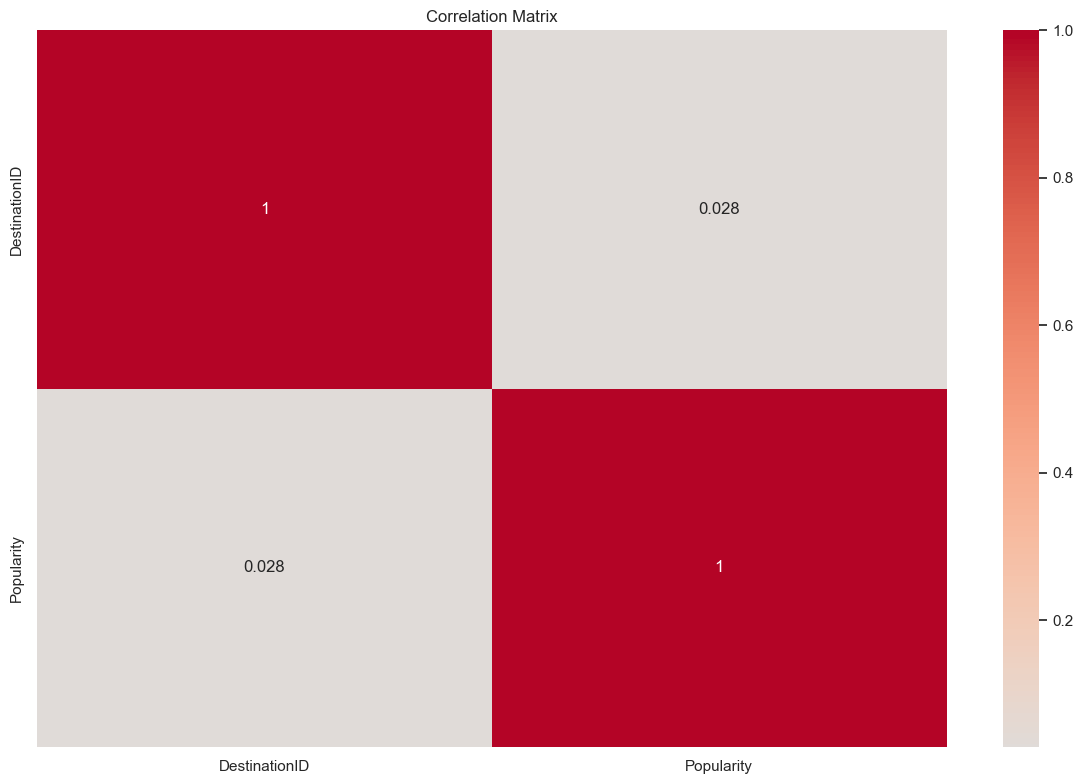


Strong correlations (|correlation| > 0.5):

No strong correlations found


In [38]:
eda_destinations.correlation_analysis()

### EDA: REVIEWS

In [39]:
eda_reviews.load_data()


Dataset Shape: (999, 5)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ReviewID       999 non-null    int64 
 1   DestinationID  999 non-null    int64 
 2   UserID         999 non-null    int64 
 3   Rating         999 non-null    int64 
 4   ReviewText     999 non-null    object
dtypes: int64(4), object(1)
memory usage: 39.2+ KB


First few rows:

   ReviewID  DestinationID  UserID  Rating            ReviewText
0         1            178     327       2  Incredible monument!
1         2            411     783       1    Loved the beaches!
2         3            927      12       2   A historical wonder
3         4            358     959       3  Incredible monument!
4         5            989     353       2    Loved the beaches!


,ReviewID,DestinationID,UserID,Rating,ReviewText
0,1,178,327,2,Incredible monument!
1,2,411,783,1,Loved the beaches!
2,3,927,12,2,A historical wonder
3,4,358,959,3,Incredible monument!
4,5,989,353,2,Loved the beaches!
...,...,...,...,...,...
994,995,231,346,5,Loved the beaches!
995,996,140,140,3,A historical wonder
996,997,823,858,5,Incredible monument!
997,998,279,839,2,Loved the beaches!


In [40]:
eda_reviews.check_data_quality()


Statistical Summary:

       ReviewID  DestinationID  UserID  Rating
count    999.00         999.00  999.00  999.00
mean     500.00         506.39  498.61    3.02
std      288.53         285.60  286.96    1.42
min        1.00           1.00    2.00    1.00
25%      250.50         273.00  252.00    2.00
50%      500.00         501.00  494.00    3.00
75%      749.50         752.00  747.50    4.00
max      999.00        1000.00  999.00    5.00


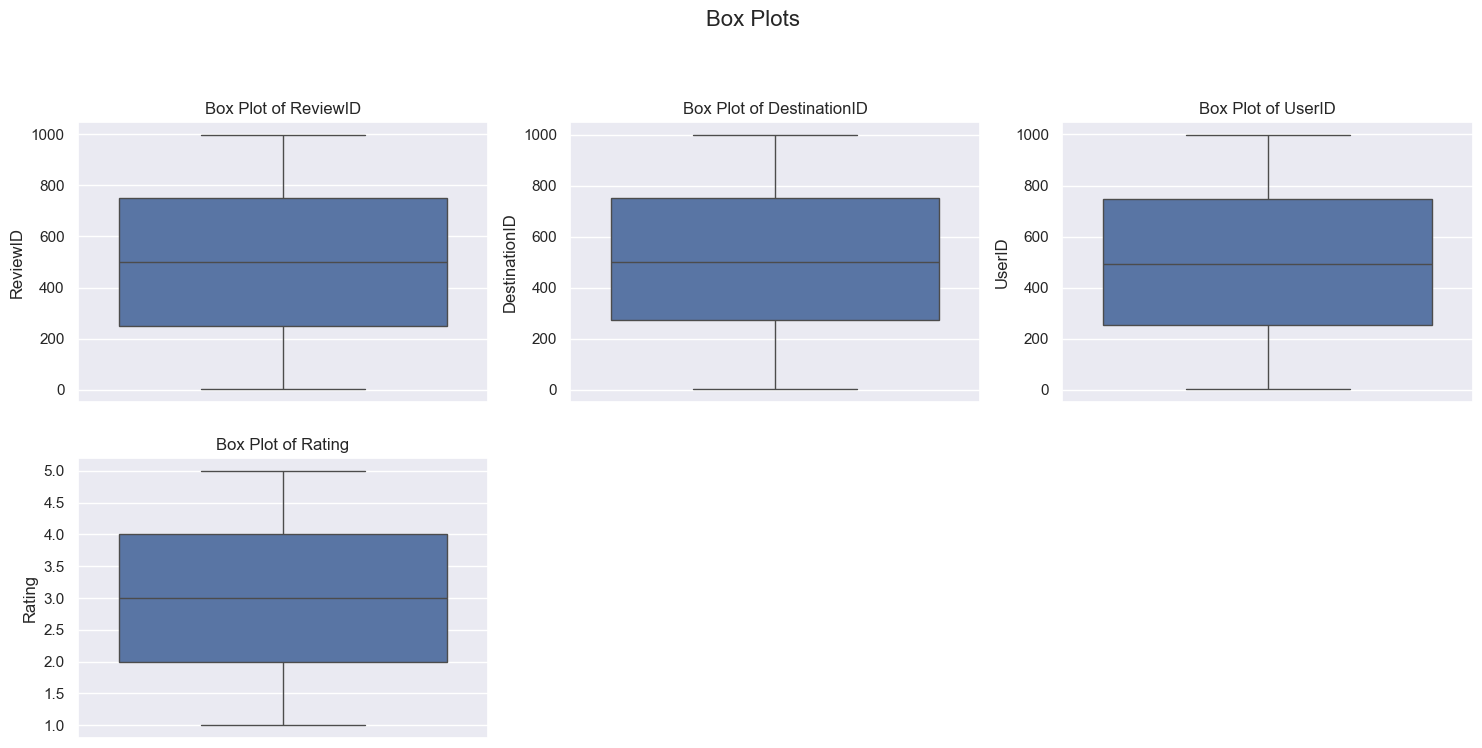

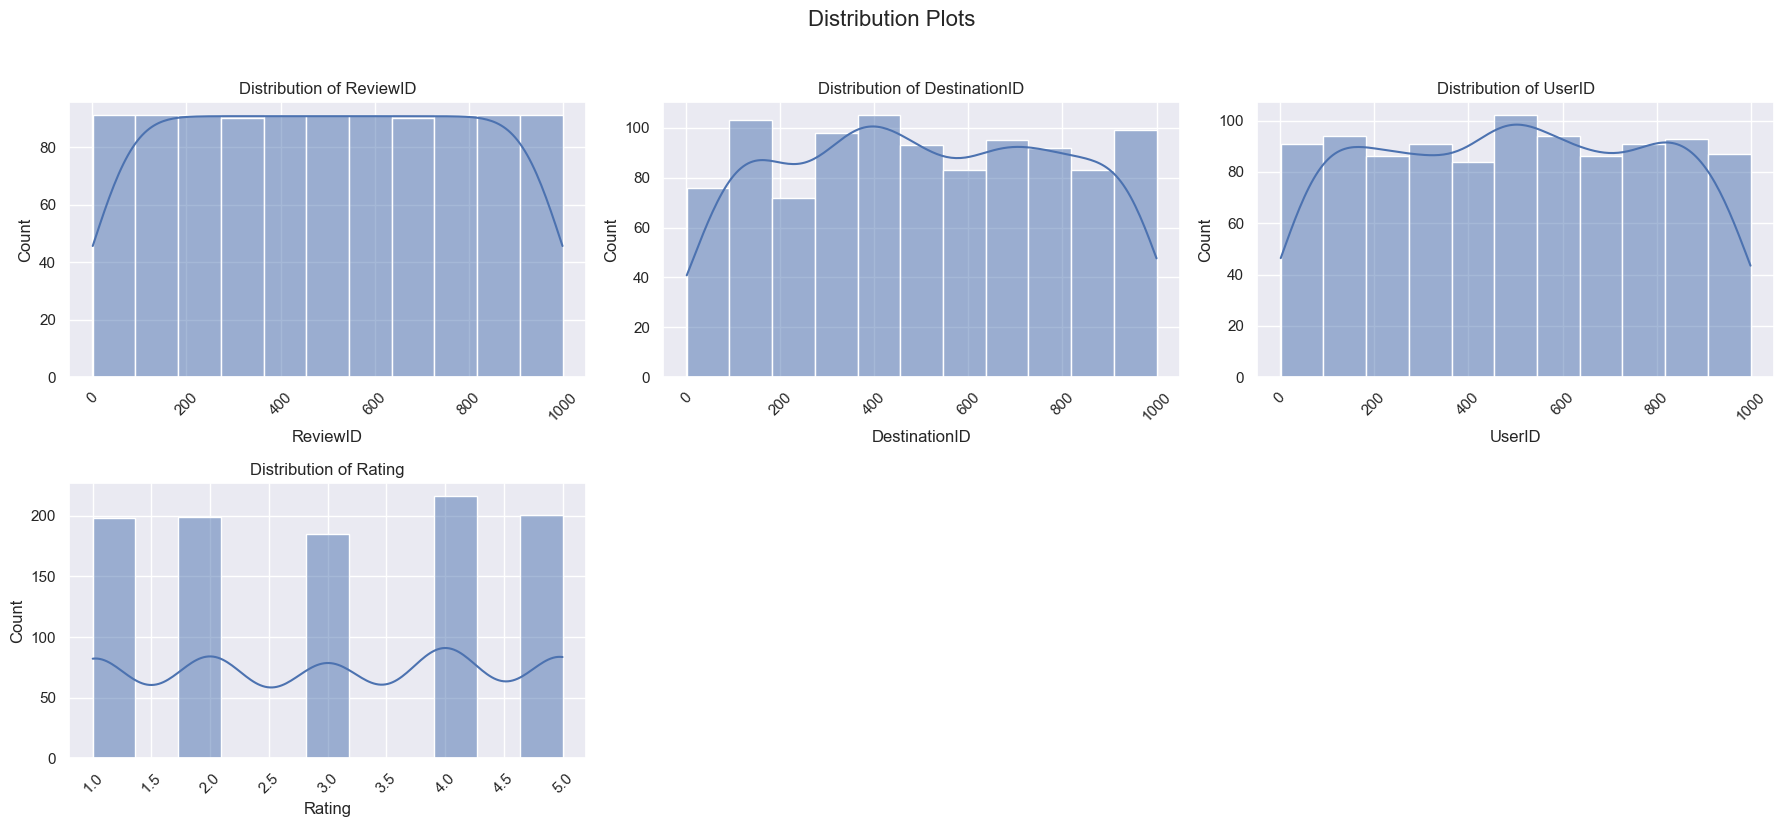

<Figure size 640x480 with 0 Axes>


Summary statistics:

       ReviewID  DestinationID  UserID  Rating
count    999.00         999.00  999.00  999.00
mean     500.00         506.39  498.61    3.02
std      288.53         285.60  286.96    1.42
min        1.00           1.00    2.00    1.00
25%      250.50         273.00  252.00    2.00
50%      500.00         501.00  494.00    3.00
75%      749.50         752.00  747.50    4.00
max      999.00        1000.00  999.00    5.00


In [41]:
eda_reviews.analyze_numerical()

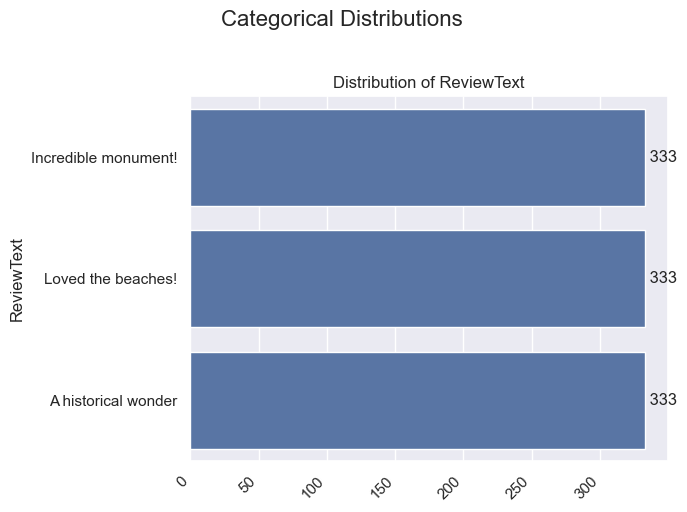


Frequency distributions (proportions):

ReviewText:
ReviewText
Incredible monument!    0.333333
Loved the beaches!      0.333333
A historical wonder     0.333333
Number of unique values: 3
Most common value: A historical wonder (33.33%)


In [42]:
eda_reviews.analyze_categorical()

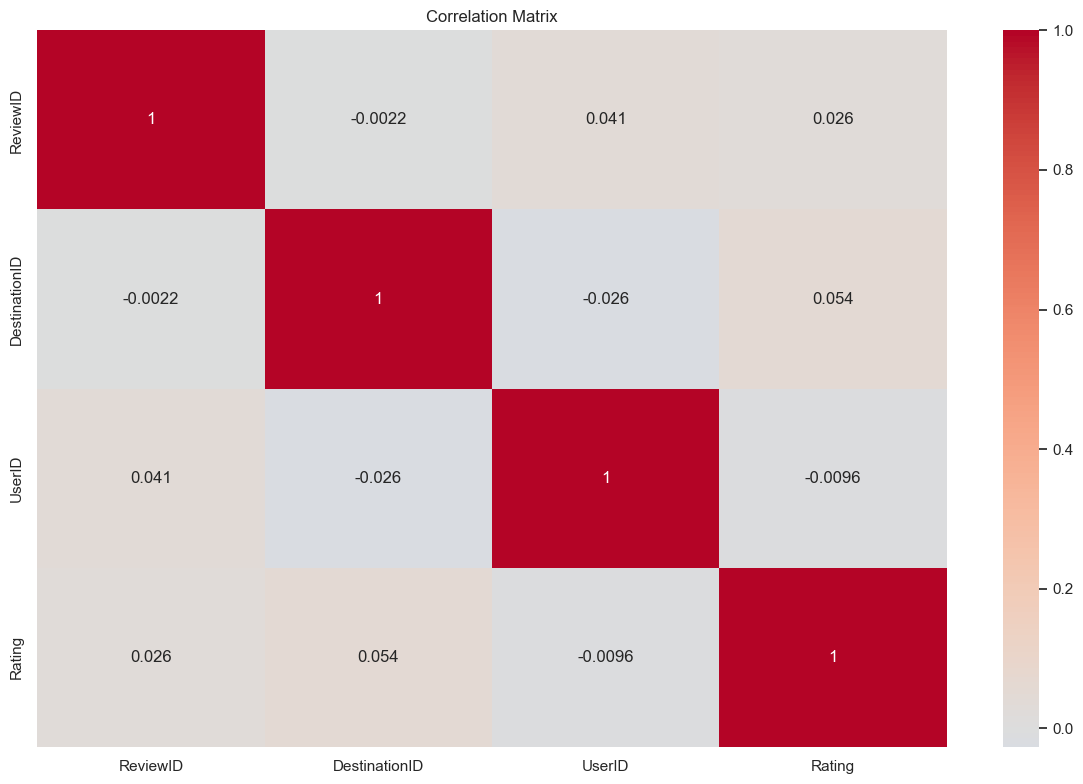


Strong correlations (|correlation| > 0.5):

No strong correlations found


In [43]:
eda_reviews.correlation_analysis()

### EDA: USER HISTORY

In [44]:
eda_user_history.load_data()


Dataset Shape: (999, 5)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   HistoryID         999 non-null    int64 
 1   UserID            999 non-null    int64 
 2   DestinationID     999 non-null    int64 
 3   VisitDate         999 non-null    object
 4   ExperienceRating  999 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 39.2+ KB


First few rows:

   HistoryID  UserID  DestinationID   VisitDate  ExperienceRating
0          1     525            760  2024-01-01                 3
1          2     184            532  2024-02-15                 5
2          3     897            786  2024-03-20                 2
3          4     470            660  2024-01-01                 1
4          5     989            389  2024-02-15                 4


,HistoryID,UserID,DestinationID,VisitDate,ExperienceRating
0,1,525,760,2024-01-01,3
1,2,184,532,2024-02-15,5
2,3,897,786,2024-03-20,2
3,4,470,660,2024-01-01,1
4,5,989,389,2024-02-15,4
...,...,...,...,...,...
994,995,129,240,2024-02-15,3
995,996,634,359,2024-03-20,3
996,997,831,78,2024-01-01,1
997,998,959,660,2024-02-15,4


In [45]:
eda_user_history.check_data_quality()


Statistical Summary:

       HistoryID  UserID  DestinationID  ExperienceRating
count     999.00  999.00         999.00            999.00
mean      500.00  497.22         493.55              2.90
std       288.53  290.58         296.68              1.40
min         1.00    1.00           2.00              1.00
25%       250.50  258.50         236.00              2.00
50%       500.00  497.00         472.00              3.00
75%       749.50  752.00         760.50              4.00
max       999.00  999.00        1000.00              5.00


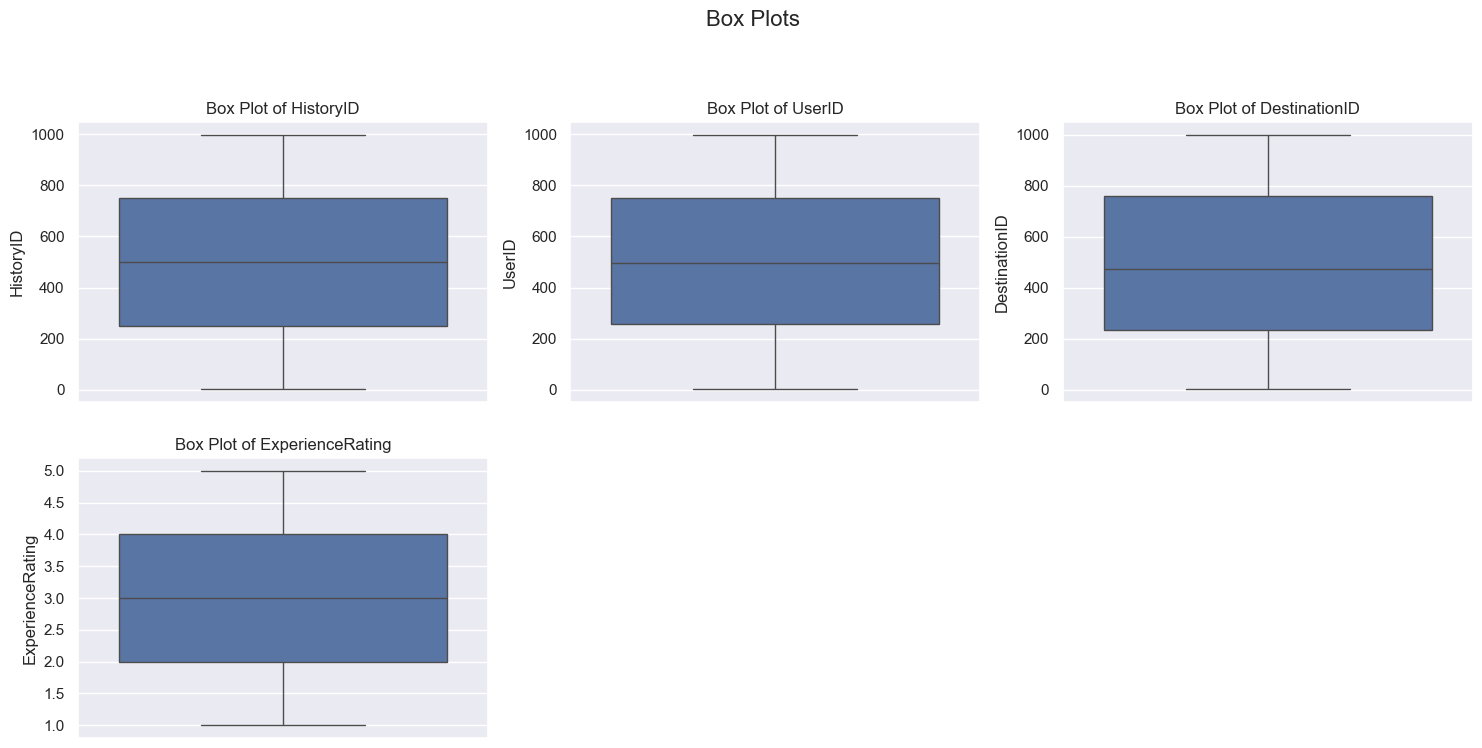

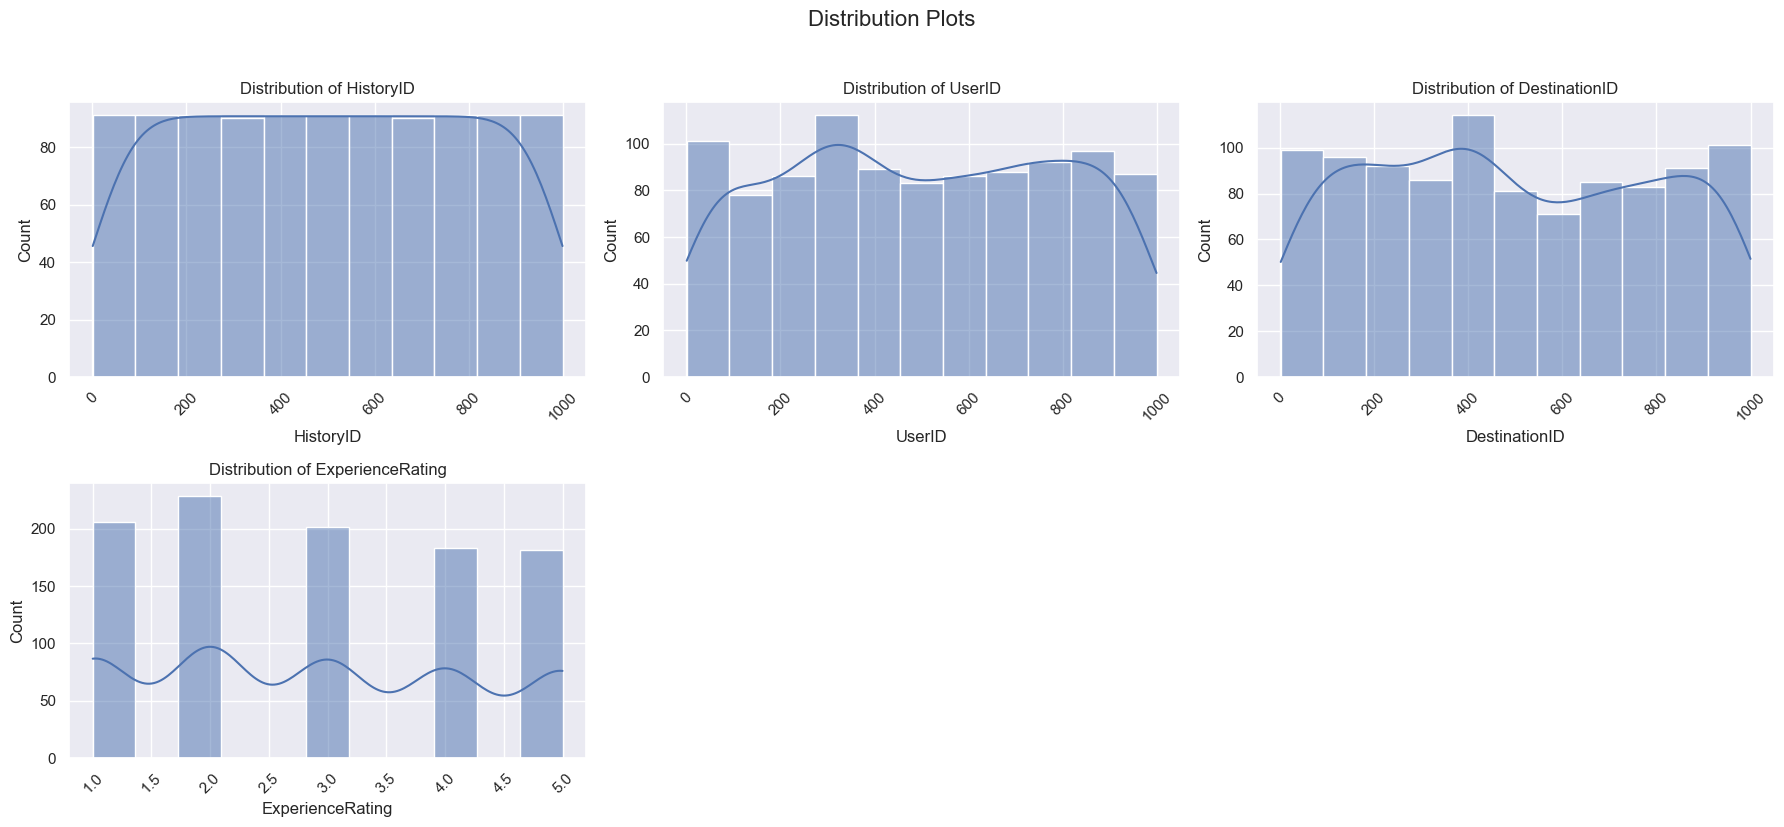

<Figure size 640x480 with 0 Axes>


Summary statistics:

       HistoryID  UserID  DestinationID  ExperienceRating
count     999.00  999.00         999.00            999.00
mean      500.00  497.22         493.55              2.90
std       288.53  290.58         296.68              1.40
min         1.00    1.00           2.00              1.00
25%       250.50  258.50         236.00              2.00
50%       500.00  497.00         472.00              3.00
75%       749.50  752.00         760.50              4.00
max       999.00  999.00        1000.00              5.00


In [46]:
eda_user_history.analyze_numerical()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


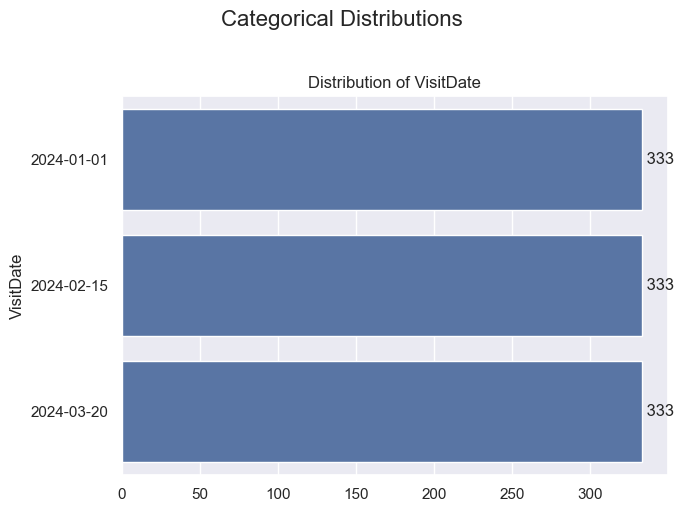


Frequency distributions (proportions):

VisitDate:
VisitDate
2024-01-01    0.333333
2024-02-15    0.333333
2024-03-20    0.333333
Number of unique values: 3
Most common value: 2024-01-01 (33.33%)


In [47]:
eda_user_history.analyze_categorical()

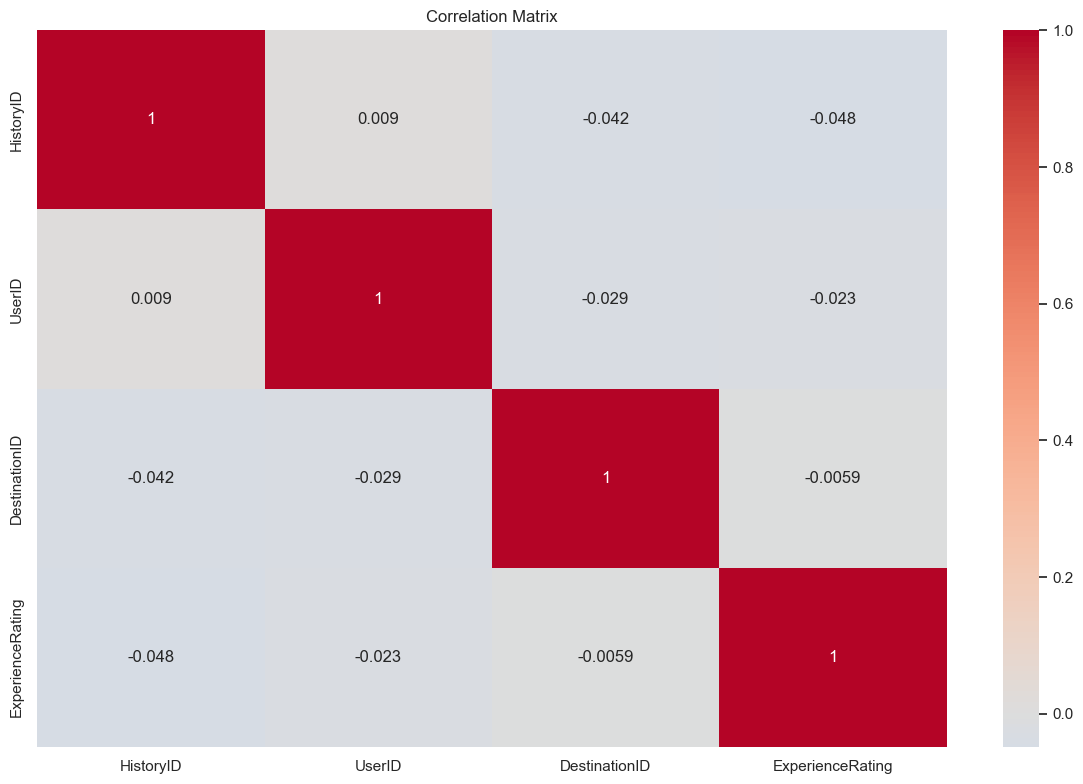


Strong correlations (|correlation| > 0.5):

No strong correlations found


In [48]:
eda_user_history.correlation_analysis()

### EDA: USERS

In [49]:
eda_users.load_data()


Dataset Shape: (999, 7)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   UserID            999 non-null    int64 
 1   Name              999 non-null    object
 2   Email             999 non-null    object
 3   Preferences       999 non-null    object
 4   Gender            999 non-null    object
 5   NumberOfAdults    999 non-null    int64 
 6   NumberOfChildren  999 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 54.8+ KB


First few rows:

   UserID   Name              Email          Preferences  Gender  NumberOfAdults  NumberOfChildren
0       1  Kavya  kavya@example.com  Beaches, Historical  Female               1                 0
1       2  Rohan  rohan@example.com    Nature, Adventure    Male               2                 2
2       3  Kavya  kavya@example.com     City, Historical  Female           

,UserID,Name,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren
0,1,Kavya,kavya@example.com,"Beaches, Historical",Female,1,0
1,2,Rohan,rohan@example.com,"Nature, Adventure",Male,2,2
2,3,Kavya,kavya@example.com,"City, Historical",Female,2,0
3,4,Anika,anika@example.com,"Beaches, Historical",Female,1,0
4,5,Tanvi,tanvi@example.com,"Nature, Adventure",Female,2,2
...,...,...,...,...,...,...,...
994,995,Karan,karan@example.com,"Nature, Adventure",Male,1,0
995,996,Dhruv,dhruv@example.com,"City, Historical",Male,1,1
996,997,Karan,karan@example.com,"Beaches, Historical",Male,1,2
997,998,Aditya,aditya@example.com,"Nature, Adventure",Male,1,1


In [50]:
eda_users.check_data_quality()


Statistical Summary:

       UserID  NumberOfAdults  NumberOfChildren
count  999.00          999.00            999.00
mean   500.00            1.50              0.98
std    288.53            0.50              0.81
min      1.00            1.00              0.00
25%    250.50            1.00              0.00
50%    500.00            2.00              1.00
75%    749.50            2.00              2.00
max    999.00            2.00              2.00


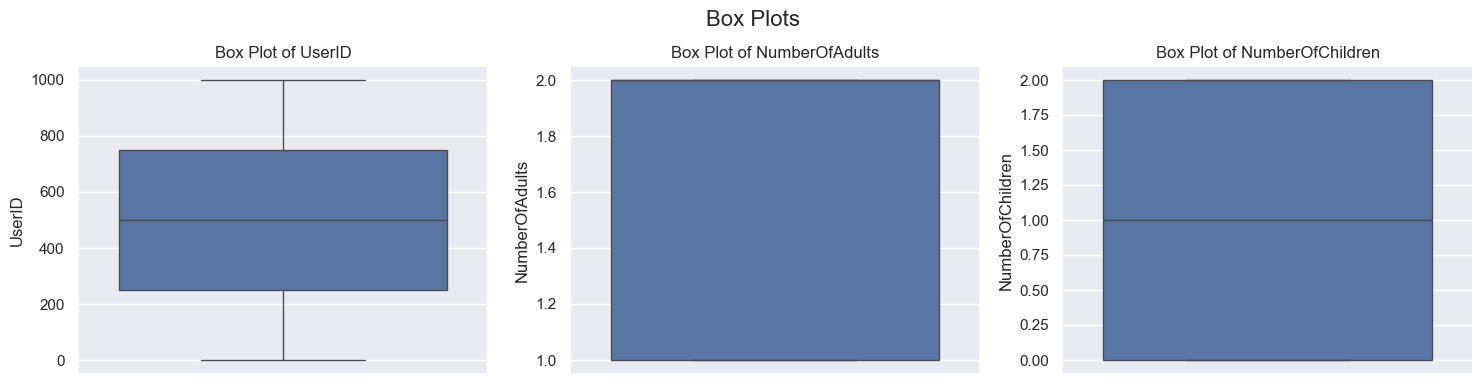

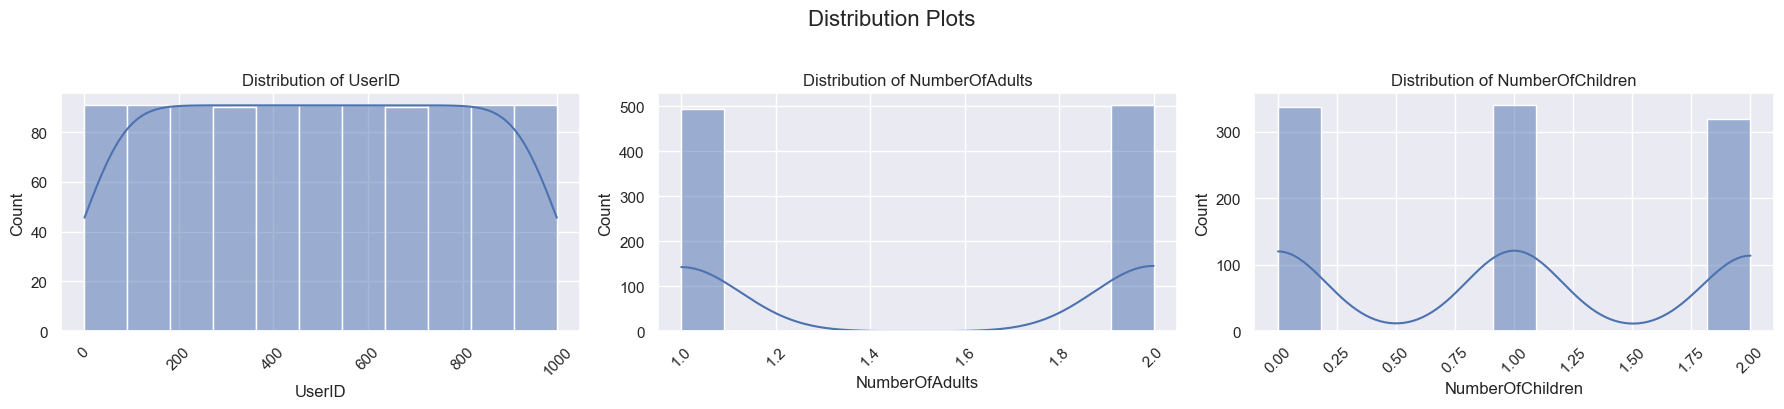

<Figure size 640x480 with 0 Axes>


Summary statistics:

       UserID  NumberOfAdults  NumberOfChildren
count  999.00          999.00            999.00
mean   500.00            1.50              0.98
std    288.53            0.50              0.81
min      1.00            1.00              0.00
25%    250.50            1.00              0.00
50%    500.00            2.00              1.00
75%    749.50            2.00              2.00
max    999.00            2.00              2.00


In [51]:
eda_users.analyze_numerical()


Note: Name has 20 categories. Showing top 10.

Note: Email has 20 categories. Showing top 10.


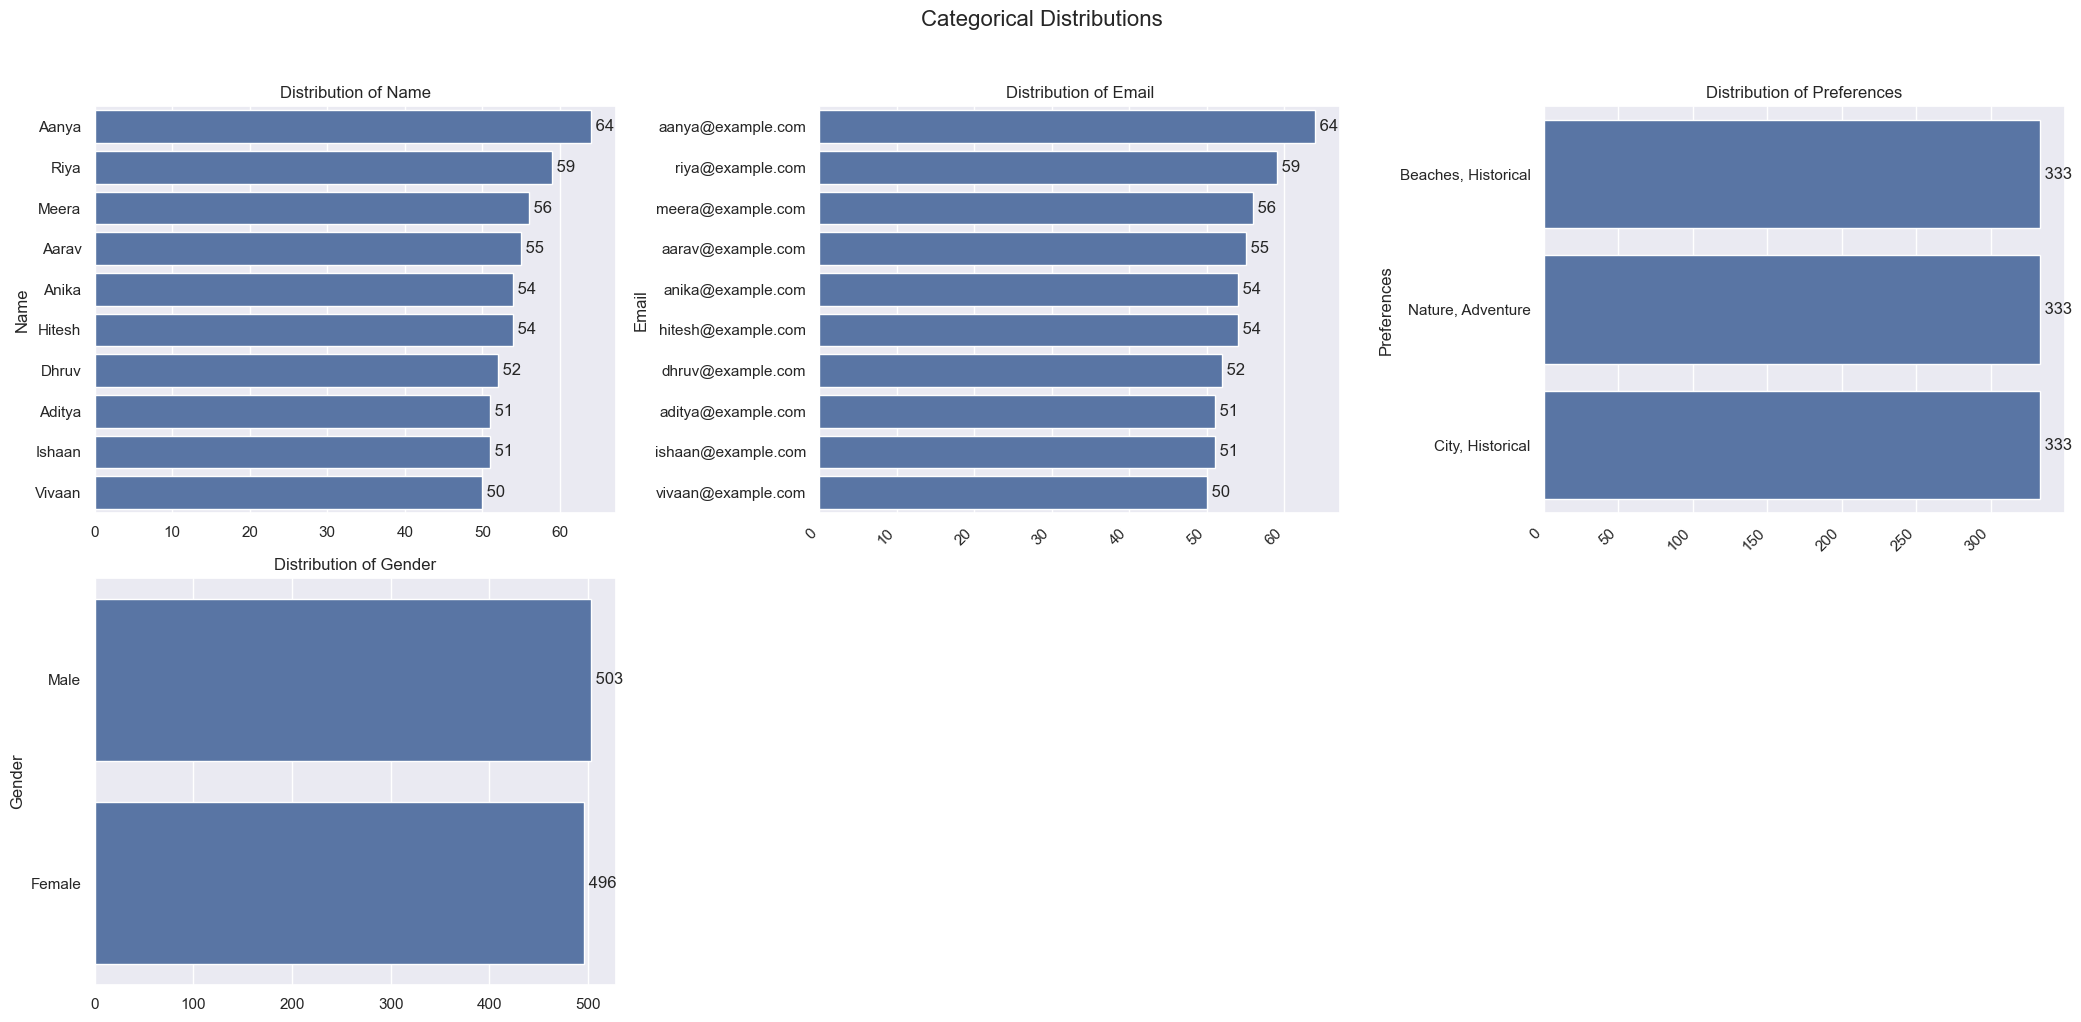


Frequency distributions (proportions):

Name:
Name
Aanya     0.064064
Riya      0.059059
Meera     0.056056
Aarav     0.055055
Anika     0.054054
Hitesh    0.054054
Dhruv     0.052052
Aditya    0.051051
Ishaan    0.051051
Vivaan    0.050050
Arjun     0.048048
Rohan     0.048048
Ritvik    0.048048
Isha      0.047047
Kavya     0.047047
Karan     0.046046
Pooja     0.045045
Tanvi     0.043043
Saanvi    0.043043
Diya      0.038038
Number of unique values: 20
Most common value: Aanya (6.41%)

Email:
Email
aanya@example.com     0.064064
riya@example.com      0.059059
meera@example.com     0.056056
aarav@example.com     0.055055
anika@example.com     0.054054
hitesh@example.com    0.054054
dhruv@example.com     0.052052
aditya@example.com    0.051051
ishaan@example.com    0.051051
vivaan@example.com    0.050050
arjun@example.com     0.048048
rohan@example.com     0.048048
ritvik@example.com    0.048048
isha@example.com      0.047047
kavya@example.com     0.047047
karan@example.com     0.0460

In [52]:
eda_users.analyze_categorical()

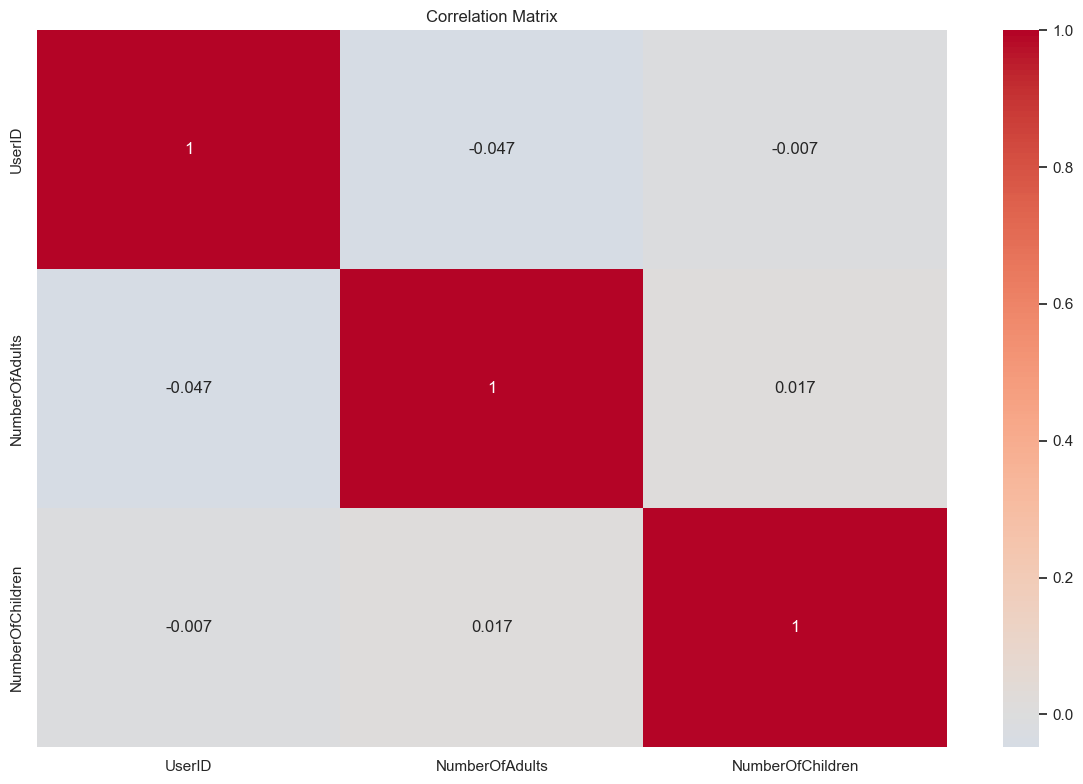


Strong correlations (|correlation| > 0.5):

No strong correlations found


In [53]:
eda_users.correlation_analysis()

## Data Preprocessing

In [54]:
eda_destinations.df.columns

Index(['DestinationID', 'Name', 'State', 'Type', 'Popularity',
       'BestTimeToVisit'],
      dtype='object')

In [60]:
# Get the destination name and id

eda_df = eda_destinations.df.iloc[:, 0:2]

eda_df.columns = ['destination_id', 'name']



In [57]:
eda_df

,id,name
0,1,Taj Mahal
1,2,Goa Beaches
2,3,Jaipur City
3,4,Kerala Backwaters
4,5,Leh Ladakh
...,...,...
995,996,Taj Mahal
996,997,Goa Beaches
997,998,Jaipur City
998,999,Kerala Backwaters


In [65]:
ratings = eda_reviews.df.iloc[:, [0, 1, 3]]

ratings.columns = ['user_id', 'destination_id', 'rating']

In [72]:
# Merge Data

data = pd.merge(eda_df, ratings, on='destination_id', how='left')

data.head()
# Check for missing values

data.isnull().sum()

data.dropna(inplace=True)


In [73]:
data.head()

,destination_id,name,user_id,rating
0,1,Taj Mahal,666.0,1.0
1,2,Goa Beaches,90.0,2.0
2,2,Goa Beaches,130.0,3.0
4,4,Kerala Backwaters,869.0,5.0
5,5,Leh Ladakh,402.0,1.0


In [63]:
data.shape

(1348, 4)

In [74]:
pivot_table = data.pivot_table(index=['user_id'], columns=['name'], values='rating')
pivot_table.head(10)

name,Goa Beaches,Jaipur City,Kerala Backwaters,Leh Ladakh,Taj Mahal
user_id,,,,,
1.0,NaN,2.0,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,1.0
3.0,2.0,NaN,NaN,NaN,NaN
4.0,NaN,3.0,NaN,NaN,NaN
5.0,NaN,NaN,2.0,NaN,NaN
6.0,NaN,4.0,NaN,NaN,NaN
7.0,3.0,NaN,NaN,NaN,NaN
8.0,NaN,NaN,NaN,1.0,NaN
9.0,NaN,2.0,NaN,NaN,NaN


In [76]:
destination_visited = pivot_table['Taj Mahal']
similar_destinations = pivot_table.corrwith(destination_visited)
similar_destinations = similar_destinations.sort_values(ascending=False)
similar_destinations

name
Taj Mahal            1.0
Goa Beaches          NaN
Jaipur City          NaN
Kerala Backwaters    NaN
Leh Ladakh           NaN
dtype: float64